# Machine Learning Assignment
ML assignment 2021.10.08 - implement AdaBoost
# 1. preprocess data

In [1]:
# import function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import datetime
import time
import math
import random
%matplotlib inline

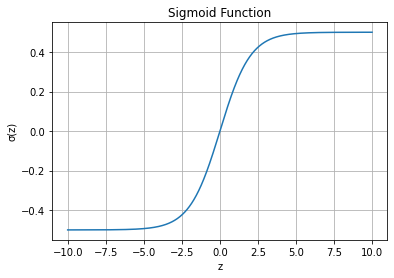

In [2]:
# 通用函数
# 激活函数
def sigmoid(input):
    return (1.0/(1 + np.exp(-input)))-0.5

# 测试sigmoid函数
z = np.arange(-10, 10, 0.01)
fz = []
for zi in z:
    fz.append(sigmoid(zi))
plt.title('Sigmoid Function')
plt.xlabel('z')
plt.ylabel('σ(z)')
plt.plot(z, fz)
plt.grid()
plt.show()

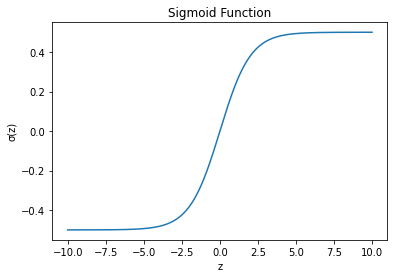

In [3]:
def sigmoid_function(z):
    fz = []
    for num in z:
        fz.append((1/(1 + math.exp(-num)))-0.5)
    return fz

z = np.arange(-10, 10, 0.01)
fz = sigmoid_function(z)
plt.title('Sigmoid Function')
plt.xlabel('z')
plt.ylabel('σ(z)')
plt.plot(z, fz)
plt.show()


In [4]:
# read data
SampleData_SavePath = "./data/A1.csv"

SampleData_pd = pd.DataFrame()
if not os.path.isfile(SampleData_SavePath):
    print(SampleData_SavePath, "is not existed.")
else :
    print(SampleData_SavePath, "is existed.")
    SampleData_pd = pd.read_csv(SampleData_SavePath)

print(SampleData_pd)
print(SampleData_pd.dtypes)

def preprocessLabel(label):
    if label == -1 :
        return 0
    else:
        return 1

SampleData_pd['label'] = SampleData_pd.apply(lambda x :preprocessLabel(x['label']), axis = 1)
print(SampleData_pd)

./data/A1.csv is existed.
   number    x    y  label
0       1   80  144      1
1       2   93  232      1
2       3  136  275     -1
3       4  147  131     -1
4       5  159   69      1
5       6  214   31      1
6       7  214  152     -1
7       8  257   83      1
8       9  307   62     -1
9      10  307  231     -1
number    int64
x         int64
y         int64
label     int64
dtype: object
   number    x    y  label
0       1   80  144      1
1       2   93  232      1
2       3  136  275      0
3       4  147  131      0
4       5  159   69      1
5       6  214   31      1
6       7  214  152      0
7       8  257   83      1
8       9  307   62      0
9      10  307  231      0


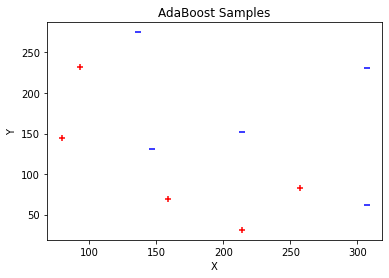

<Figure size 432x288 with 0 Axes>

In [5]:
# 将数据显示出来
plt.title("AdaBoost Samples")
plt.xlabel('X')
plt.ylabel('Y')

for index, row in SampleData_pd.iterrows():
    if row['label'] == 1:
        plt.scatter(row['x'], row['y'], marker='+', color='red')
    else:
        plt.scatter(row['x'], row['y'], marker='_', color='blue')
plt.show()
plt.savefig("./picture/samples.jpg")

In [19]:
# 乱序，并将标签与数据分割出来。
# 分割的作用是方便与后面进行错误率的计算。这样混合在一起的数据集、单纯数据集、标签集都有了。
Samples = SampleData_pd.sample(frac=1).copy()

Samples_data = Samples.iloc[:,:3].copy()
Labels_data = Samples.iloc[:,3].copy()
# print(Samples)
# print(Labels)

print(Samples)

   number    x    y  label
0       1   80  144      1
9      10  307  231      0
2       3  136  275      0
4       5  159   69      1
7       8  257   83      1
8       9  307   62      0
6       7  214  152      0
1       2   93  232      1
3       4  147  131      0
5       6  214   31      1


# 2. 实现adaboost
- 步骤
    1. 实现弱分类器
    2. 实现样本的权重调整
    3. 实现弱分类器的权重调整

## 2.1. 实现弱分类器
- 弱分类器是通过自己观察来实现弱分类器的。
- 主要步骤是：
    1. 建立$f(x)$，并选择$\theta$。
    2. 选择一个$h(x)$作为弱分类器的激活函数。
    3. 将弱分类器的权重和弱分类器结合，实现$\sum\limits_{t=1}^T\alpha_th_t(x)$。

### 2.1.1. 实现第一个弱分类器，$f(y)=y-\theta, \theta=100, h(x)=\begin{cases}0,  &\text{if  sigmod(f(x))>=0}\\ 1, & \text{if  sigmod(f(x))<0} \\\end{cases}$

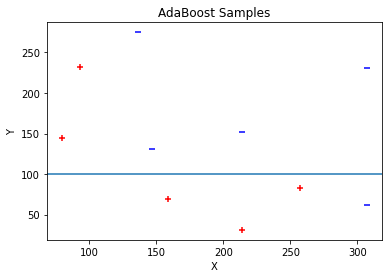

<Figure size 432x288 with 0 Axes>

In [7]:
# 第一个弱分类器示意图
plt.title("AdaBoost Samples")
plt.xlabel('X')
plt.ylabel('Y')

for index, row in SampleData_pd.iterrows():
    if row['label'] == 1:
        plt.scatter(row['x'], row['y'], marker='+', color='red')
    else:
        plt.scatter(row['x'], row['y'], marker='_', color='blue')
plt.axhline(100)
plt.show()
plt.savefig("./picture/weak_classifier0.jpg")

In [8]:
# 由于例子中的数据比较简单，所以将f(x)和h(x)一起实现了。
def wc0_fx_hx(input):
    temp = sigmoid(input - 100)
    if temp >= 0:
        Predict_Label = 0
    else:
        Predict_Label = 1
    # print(Predict_Label)
    return Predict_Label

Samples['wc0_label'] = Samples['y'].apply(lambda xx :wc0_fx_hx(xx))
print(Samples)

   number    x    y  label  wc0_label
8       9  307   62      0          1
3       4  147  131      0          0
5       6  214   31      1          1
7       8  257   83      1          1
1       2   93  232      1          0
9      10  307  231      0          0
0       1   80  144      1          0
6       7  214  152      0          0
4       5  159   69      1          1
2       3  136  275      0          0


In [9]:
# 判断这个分类器的准确率，要求这个弱分类器的准去率大于0.5
Samples['Accuracy0'] = np.where(Samples['label'] == Samples['wc0_label'], 1, 0)
Result0 = Samples['Accuracy0'].value_counts()
# 准确率是为判断正确的个数除以总样本数。
Accuracy0 = Result0.loc[1]/Samples.shape[0]
print("Accuracy of the first weak classifier is :" + str(Accuracy0))

Accuracy of the first weak classifier is :0.7


### 2.1.2. 实现第二个弱分类器，$f(y)=x-\theta, \theta=120, h(x)=\begin{cases}0,  &\text{if  sigmod(f(x))>=0}\\ 1, & \text{if  sigmod(f(x))<0} \\\end{cases}$

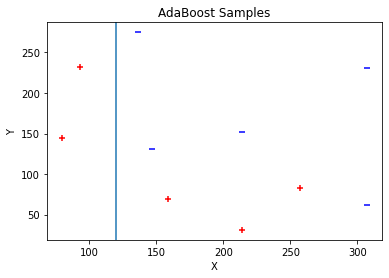

<Figure size 432x288 with 0 Axes>

In [10]:
# 第二个弱分类器示意图
plt.title("AdaBoost Samples")
plt.xlabel('X')
plt.ylabel('Y')

for index, row in SampleData_pd.iterrows():
    if row['label'] == 1:
        plt.scatter(row['x'], row['y'], marker='+', color='red')
    else:
        plt.scatter(row['x'], row['y'], marker='_', color='blue')
plt.axvline(120)
plt.show()
plt.savefig("./picture/weak_classifier1.jpg")

In [11]:
def wc1_fx_hx(input):
    temp = sigmoid(input - 120)
    if temp >= 0:
        Predict_Label = 0
    else:
        Predict_Label = 1
    # print(Predict_Label)
    return Predict_Label

Samples['wc1_label'] = Samples['x'].apply(lambda xx :wc1_fx_hx(xx))
print(Samples)

   number    x    y  label  wc0_label  Accuracy0  wc1_label
8       9  307   62      0          1          0          0
3       4  147  131      0          0          1          0
5       6  214   31      1          1          1          0
7       8  257   83      1          1          1          0
1       2   93  232      1          0          0          1
9      10  307  231      0          0          1          0
0       1   80  144      1          0          0          1
6       7  214  152      0          0          1          0
4       5  159   69      1          1          1          0
2       3  136  275      0          0          1          0


In [12]:
# 判断这个分类器的准确率，要求这个弱分类器的准去率大于0.5
Samples['Accuracy1'] = np.where(Samples['label'] == Samples['wc1_label'], 1, 0)
Result1 = Samples['Accuracy1'].value_counts()
# 准确率是为判断正确的个数除以总样本数。
Accuracy1 = Result1.loc[1]/Samples.shape[0]
print("Accuracy of the second weak classifier is :" + str(Accuracy1))

Accuracy of the second weak classifier is :0.7


### 2.1.3. 实现第三个弱分类器，$f(y)=x-\theta, \theta=240, h(x)=\begin{cases}0,  &\text{if  sigmod(f(x))>=0}\\ 1, & \text{if  sigmod(f(x))<0} \\\end{cases}$

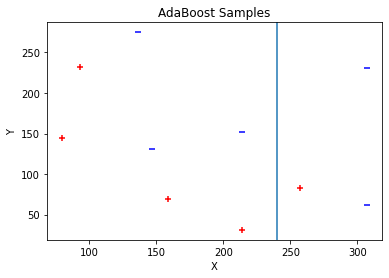

<Figure size 432x288 with 0 Axes>

In [13]:
# 第三个弱分类器示意图
plt.title("AdaBoost Samples")
plt.xlabel('X')
plt.ylabel('Y')

for index, row in SampleData_pd.iterrows():
    if row['label'] == 1:
        plt.scatter(row['x'], row['y'], marker='+', color='red')
    else:
        plt.scatter(row['x'], row['y'], marker='_', color='blue')
plt.axvline(240)
plt.show()
plt.savefig("./picture/weak_classifier2.jpg")

In [14]:
def wc2_fx_hx(input):
    temp = sigmoid(input - 240)
    if temp >= 0:
        Predict_Label = 0
    else:
        Predict_Label = 1
    # print(Predict_Label)
    return Predict_Label

Samples['wc2_label'] = Samples['x'].apply(lambda xx :wc2_fx_hx(xx))
print(Samples)

   number    x    y  label  wc0_label  Accuracy0  wc1_label  Accuracy1  \
8       9  307   62      0          1          0          0          1   
3       4  147  131      0          0          1          0          1   
5       6  214   31      1          1          1          0          0   
7       8  257   83      1          1          1          0          0   
1       2   93  232      1          0          0          1          1   
9      10  307  231      0          0          1          0          1   
0       1   80  144      1          0          0          1          1   
6       7  214  152      0          0          1          0          1   
4       5  159   69      1          1          1          0          0   
2       3  136  275      0          0          1          0          1   

   wc2_label  
8          0  
3          1  
5          1  
7          0  
1          1  
9          0  
0          1  
6          1  
4          1  
2          1  


In [15]:
# 判断这个分类器的准确率，要求这个弱分类器的准去率大于0.5
Samples['Accuracy2'] = np.where(Samples['label'] == Samples['wc2_label'], 1, 0)
Result2 = Samples['Accuracy2'].value_counts()
print(Result2)
# 准确率是为判断正确的个数除以总样本数。
Accuracy2 = Result2.loc[1]/Samples.shape[0]
print("Accuracy of the third weak classifier is :" + str(Accuracy2))

1    6
0    4
Name: Accuracy2, dtype: int64
Accuracy of the third weak classifier is :0.6


### 2.1.4. 实现第四个弱分类器，$f(y)=y-\theta, \theta=240, h(x)=\begin{cases}0,  &\text{if  sigmod(f(x))>=0}\\ 1, & \text{if  sigmod(f(x))<0} \\\end{cases}$

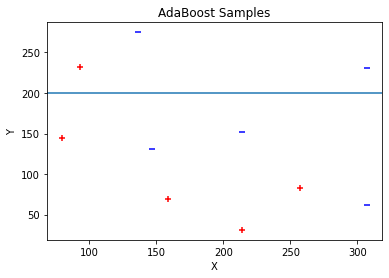

<Figure size 432x288 with 0 Axes>

In [16]:
# 第四个弱分类器
plt.title("AdaBoost Samples")
plt.xlabel('X')
plt.ylabel('Y')

for index, row in SampleData_pd.iterrows():
    if row['label'] == 1:
        plt.scatter(row['x'], row['y'], marker='+', color='red')
    else:
        plt.scatter(row['x'], row['y'], marker='_', color='blue')
plt.axhline(200)
plt.show()
plt.savefig("./picture/weak_classifier3.jpg")

In [17]:
def wc3_fx_hx(input):
    temp = sigmoid(input - 200)
    if temp >= 0:
        Predict_Label = 0
    else:
        Predict_Label = 1
    # print(Predict_Label)
    return Predict_Label

Samples['wc3_label'] = Samples['y'].apply(lambda xx :wc3_fx_hx(xx))
print(Samples)

   number    x    y  label  wc0_label  Accuracy0  wc1_label  Accuracy1  \
8       9  307   62      0          1          0          0          1   
3       4  147  131      0          0          1          0          1   
5       6  214   31      1          1          1          0          0   
7       8  257   83      1          1          1          0          0   
1       2   93  232      1          0          0          1          1   
9      10  307  231      0          0          1          0          1   
0       1   80  144      1          0          0          1          1   
6       7  214  152      0          0          1          0          1   
4       5  159   69      1          1          1          0          0   
2       3  136  275      0          0          1          0          1   

   wc2_label  Accuracy2  wc3_label  
8          0          1          1  
3          1          0          1  
5          1          1          1  
7          0          0          1  


In [18]:
# 判断这个分类器的准确率，要求这个弱分类器的准去率大于0.5
Samples['Accuracy3'] = np.where(Samples['label'] == Samples['wc3_label'], 1, 0)
Result3 = Samples['Accuracy3'].value_counts()
print(Result3)
# 准确率是为判断正确的个数除以总样本数。
Accuracy3 = Result3.loc[1]/Samples.shape[0]
print("Accuracy of the third weak classifier is :" + str(Accuracy3))

1    6
0    4
Name: Accuracy3, dtype: int64
Accuracy of the third weak classifier is :0.6


# 弱分类器是需要训练的。[训练的过程](https://www.cnblogs.com/chenpi/p/5128235.html)
- 训练弱分类器的过程就是从已有的特征中选出一个特征以及其对应的阈值，使样本分错的错误率最低，即寻找一个最小分错率的过程。
  1. 最小错误率初始化为无穷大；
  2. 遍历样本的所有特征（本例子每个样本有三个特征，即遍历这三个特征值）；
  3. 求出该特征值步长（不同特征不一样），（最大特征值-最小特征值）/步长移动次数，如本例，假设步长移动次数为10，则第一个特征步长为（7-1）/10 = 0.6；
  4. 根据特征值步长开始从最小特征值遍历到最大特征值；
  5. 遍历判断符号，大于还是小于；
  6. 计算出阈值（根据最小特征值及步长），根据阈值、符号、及特征索引、开始对样本分类；
  7. 根据每个样本权重以及分类结果计算分错率，若该分错率小于最小分错率，则更新最小分错率；
  8. 返回最小分错率下的特征索引、符号、阈值，即得到弱分类器。

In [ ]:
# 更新theta，也就是弱分类器的阈值。用于做出新的分类器。
# 也就是计算出新的阈值。通过步长和训练的轮次输出当前的阈值
xMax = Samples['x'].max()
xMin = Samples['x'].min()
yMax = Samples['y'].max()
yMin = Samples['y'].min()

numberSteps = SampleData_pd.shape[0]

xStepSize = (xMax - xMin) / numberSteps
yStepSize = (yMax - yMin) / numberSteps

def update_theta(i, max, min):
    """[summary]
    更新theta，也就是弱分类器的阈值。用于做出新的分类器。
    也就是计算出新的阈值。通过步长和训练的轮次输出当前的阈值。
    Args:
        i ([int]): [训练的轮次]
        max ([float]): [该特征的最大值]
        min ([float]): [该特征的最小值]

    Returns:
        [type]: [description]
    """
    stepSize = (max - min) / numberSteps
    return min + stepSize * i

In [ ]:
# 定义弱分类器的形式。一共有两种，一种是按照特征x来进行分类的，一种是按照特征y来进行分类的。

# 实际上是仅仅是在两个特征的样本中，只用x,y轴的形式进行分类，分类器也有四种。除了x，y轴的2两类，
# 还可以定义左边是正类或者是负类。这样就增加了2类。这里不再做讨论。

# 因为只有两种分类器，所以通过抛硬币的形式来确定模型的类型。
# 这个类型通过上层调用的时候确定theta输入值的形式就可。
def WeakClassifier(input, theta):
    temp = sigmoid((input - theta))
    if temp >= 0:
        Predict_Label = 0
    else:
        Predict_Label = 1
    return Predict_Label

In [ ]:
# 计算分类错误率
# 错误率就是被预测错误的样本的样本权重之和。
def update_Error_rate(labels, pred, Dt):
    ret = 0
    for i in range(labels.shape[0]):
        if labels[i] != pred[i]:
            ret += Dt[i]
    return ret

## 2.2. 实现样本权重调整
- 因为有10个样本，那么就设置10个样本权重。定义dti表示样本权重的list。
- **样本权重之和需要为1**。
- 而且**初始化情况下，所有样本的权重均相等**。

In [20]:
SampleData_pd.shape[0]

10

In [22]:
# - **样本权重之和需要为1**。
# - 而且**初始化情况下，所有样本的权重均相等**。
Dt = [(1.0/(SampleData_pd.shape[0])) for i in range(SampleData_pd.shape[0])]
print(Dt)

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


In [ ]:
# 更新弱分类器的权重
def update_Dt(Error_rate):
    # 如果错误率为0，那么这个分类器权重为1。
    if Error_rate == 0:
        return 1
    # 如果错误率为0.5，那么这个分类器和盲猜没有区别，将其权重赋值为最小值。
    elif Error_rate == 0.5:
        return 0.001
    else:
        # 按照公式计算弱分类器的权重。
        return 0.5 * np.log((1 - Error_rate) / Error_rate)

In [28]:
for i in range(10):
    print(random.randint(0,1))

0
1
0
1
1
0
1
1
1
1


In [25]:
a = np.array([8,0,3,5,2,2])
sortLoc = np.argsort(a)
sortVal = np.sort(a)
print(sortLoc)
print(sortVal)

[1 4 5 2 3 0]
[0 2 2 3 5 8]


In [ ]:
# 首先实现弱分类器的训练
# 不知道理解是否正确：弱分类器一开始都是初始化了n个。而不是一个一个训练出来的。

class TrainWeakClassifier:
    # 用于临时存储分类的标签，用于计算错误率。
    trainLabels = []
    # 用于临时存储错误率。
    trainErrorRate = []
    
    def __init__(self) -> None:
        pass
    
    def inputParametersToWeakClassifierTrain(self, type, maximum, minimum, Dt):
        """[summary]

        Args:
            type ([string]): [input 'x' or 'y']
            maximum ([int]): [对应type上的最大值]
            minimum ([int]): [对应type上的最小值]
            Dt ([type]): [初始情况下输入Dt都是0.1，后面更新了之后就输入新的Dt]

        Returns:
            [type]: [description]
        """
        for i in range(SampleData_pd.shape[0]):
            theta = update_theta(i, maximum, minimum)
            self.trainLabels.append(WeakClassifier(SampleData_pd[i, type], theta))
        # 这里的Dt需要填入初始化的Dt。
        self.trainErrorRate.append(update_Error_rate(self.trainLabels, Labels_data, Dt))
        # 然后从其中选出1个错误率最小的弱分类器，同时得出最小的theta。
        thetaMin_temp_locatin = self.trainErrorRate.index(max(self.trainErrorRate))
        thetaMin_temp = self.trainErrorRate[thetaMin_temp_locatin]
        return thetaMin_temp

    def TrainWeakClassifier(self):
        # 按照样本的数量来确定进行弱分类器的训练次数。
        # 这个过程中并不修改样本的权重。
        
        thetaMin = 0

        # 使用随机数来确定弱分类器是x轴还是y轴类型的分类器。0是x型弱分类器，1是y型弱分类器。
        # 定义弱分类器的形式。一共有两种，一种是按照特征x来进行分类的，一种是按照特征y来进行分类的。
        # 因为只有两种分类器，所以通过抛硬币的形式来确定模型的类型。
        classifierType = random.randint(0,1)
        if classifierType == 0:
            thetaMin = self.inputParametersToWeakClassifierTrain('x', xMax, xMin, Dt)
        else:
            thetaMin = self.inputParametersToWeakClassifierTrain('y', yMax, yMin, Dt)
        



## 2.3. 弱分类器的权重。

In [23]:
alpha_i = [0.25 for i in range(4)]
print(alpha_i)

[0.25, 0.25, 0.25, 0.25]


In [24]:
# 更新样本的权重
def update_Dt(Dt, alpha, labels, pred):
    new_Dt = []
    for i in range(len(labels)):
        new_Dt.append(Dt[i] * np.exp( -alpha * labels[i] * pred[i]))
    return np.array(new_Dt/sum(new_Dt)).reshape([len(labels),1])

In [25]:
SampleData_pd.shape[1]

4